# Correlations with MT from Whitaker Vertes 2016

In [10]:
%cd work/notebooks

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks


In [11]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
from enrichments import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");


Attaching package: ‘ggpp’



    annotate




In [13]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [14]:
%%R
load("../data/hcp_baseline_ct_mt.RData")

In [16]:
ct_t = %Rget ct.sl.t
mt_t = %Rget mt.frac.sl.t
mt_100_t = %Rget mt.sl.t

In [30]:
frantisek_CT_MT_complete = pd.DataFrame({'dCT': ct_t, 'dMT': mt_t, 'dMT100': mt_100_t[16:]}, index=range(1,361))
frantisek_CT_MT_complete.join(dme_3d_ds5.clean_scores()).corr().round(2)
# frantisek_CT_MT_complete.to_csv("../data/frantisek_ct_mt_complete.csv")

,dCT,dMT,dMT100,G1,G2,G3
dCT,1.00,-0.26,-0.41,-0.26,-0.27,-0.17
dMT,-0.26,1.00,0.62,0.17,0.16,0.43
dMT100,-0.41,0.62,1.00,-0.03,-0.02,0.38
G1,-0.26,0.17,-0.03,1.00,-0.00,-0.00
G2,-0.27,0.16,-0.02,-0.00,1.00,0.00
G3,-0.17,0.43,0.38,-0.00,0.00,1.00


In [6]:
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
dk_scores = dm_hcp_3d_ds5.score_in_dk()
dk_null_grads = np.load(f"../outputs/permutations/hcp_3d_ds5_spin_5000_in_dk.npy")

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [37]:
version = dm_hcp_3d_ds5
weights = version.weights.iloc[:, :3]
null_weights = shuffle_gene_weights(version.weights, n=5000, rank=False)

In [43]:
ctmt_pls1 = pd.read_csv("../data/whitakervertes2016_genes.csv", usecols=[0,1]).set_index('PLS1 ranked genes')
ctmt_pls2 = pd.read_csv("../data/whitakervertes2016_genes.csv", usecols=[2,3]).set_index('PLS2 ranked genes')

In [112]:
weights.join(ctmt_pls2).corr(method='pearson')

,0,1,2,PLS2 bootstrapped weights
0,1.000000,-0.038896,0.018463,0.227187
1,-0.038896,1.000000,0.104674,0.406925
2,0.018463,0.104674,1.000000,-0.564209
PLS2 bootstrapped weights,0.227187,0.406925,-0.564209,1.000000


In [78]:
matched_genes = np.intersect1d(weights.index, ctmt_pls2.index)
mask = np.isin(weights.index, matched_genes)
pls2_matched = ctmt_pls2.loc[matched_genes].values.squeeze()

In [83]:
def corr_np(data1, data2):
    mean1 = data1.mean() 
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr

def pearson_np(x, y):
    return np.array([corr_np(x[:, i], y) for i in range(x.shape[1])])

null_corrs = np.zeros((null_weights.shape[2], 3))
for i in range(3):
    null_corrs[:,i] = pearson_np(null_weights[mask,i,:], pls2_matched)

In [109]:
true_corrs = pearson_np(weights.values[mask,:], pls2_matched)
compute_null_p(
    pd.DataFrame(true_corrs).T.set_axis(['pls2']),
    pd.DataFrame(null_corrs).assign(label='pls2')
)


,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig
0,pls2,0,1.0,0.227187,0.000371,0.012153,18.664022,True,0.0,0.0,True
1,pls2,1,1.0,0.406925,0.000375,0.012203,33.316268,True,0.0,0.0,True
2,pls2,2,0.0,-0.564209,-0.000092,0.012203,-46.228090,False,0.0,0.0,True


## Read data and convert to HCP

In [7]:
(pd.read_csv('../data/whitakervertes2016_complete_308.tex', sep='&', header=None)
    .replace(".*textless","",regex=True)
    .replace("\\\\","",regex=True)
    .replace(" ","",regex=True)
    .set_axis(['lobe','region','hemi','n_sub_regions','CT','CT_delta','CT_p','MT','MT_delta','MT_p','PLS2','degree','closeness'],axis=1)
    .assign(label = lambda x: x['hemi']+'h_'+x['region'])
    .assign(region = lambda x: pd.Categorical(x['region'], ordered=True, categories=dk_scores['label'].str.replace("lh_","")))
    .sort_values(['region','n_sub_regions']).head(20)
)#.to_csv("../data/whitakervertes2016_complete_308.csv")

,lobe,region,hemi,n_sub_regions,CT,CT_delta,CT_p,MT,MT_delta,MT_p,PLS2,degree,closeness,label
37,temporal,bankssts,l,1,2.84,-18.19,.001,0.86,5.43,.001,-0.00,47,0.50,lh_bankssts
55,temporal,bankssts,r,1,2.85,-13.63,.001,0.87,5.22,.001,0.03,20,0.44,rh_bankssts
36,temporal,bankssts,r,2,2.86,-16.67,.001,0.87,5.43,.001,0.02,17,0.44,rh_bankssts
78,temporal,bankssts,l,2,2.80,-16.87,.001,0.88,4.65,.001,-0.00,55,0.51,lh_bankssts
267,frontal,caudalanteriorcingulate,l,1,2.54,-11.49,.050,0.90,2.10,.076,-0.04,2,0.34,lh_caudalanteriorcingulate
288,frontal,caudalanteriorcingulate,r,1,2.63,-10.61,.024,0.89,1.34,.192,-0.04,1,0.26,rh_caudalanteriorcingulate
59,frontal,caudalmiddlefrontal,l,1,2.94,-20.91,.001,0.87,5.00,.001,0.08,83,0.53,lh_caudalmiddlefrontal
158,frontal,caudalmiddlefrontal,r,1,2.64,-14.51,.001,0.88,3.79,.001,0.09,30,0.47,rh_caudalmiddlefrontal
171,frontal,caudalmiddlefrontal,l,2,2.93,-14.18,.001,0.91,3.67,.001,0.09,95,0.55,lh_caudalmiddlefrontal
187,frontal,caudalmiddlefrontal,r,2,2.99,-19.71,.001,0.91,3.45,.002,0.05,81,0.53,rh_caudalmiddlefrontal


In [8]:
ctmt = (pd.read_csv("../data/whitakervertes2016_complete_308.csv", index_col=0)
        .loc[:,['hemi','CT','CT_delta','MT','MT_delta','PLS2','degree','closeness']]
)
ctmt.sort_index()
# ctmt = (ctmt.query("hemi=='l'").drop('hemi',axis=1), ctmt.query("hemi=='r'").drop('hemi',axis=1))

,hemi,CT,CT_delta,MT,MT_delta,PLS2,degree,closeness
0,l,2.79,-26.96,0.87,8.92,0.06,24,0.41
1,r,2.52,-19.42,0.88,8.03,0.06,49,0.50
2,l,2.73,-23.65,0.86,7.67,0.08,42,0.48
3,l,2.97,-28.56,0.84,7.20,0.06,72,0.53
4,r,2.59,-20.63,0.86,7.13,0.06,40,0.45
...,...,...,...,...,...,...,...,...
303,l,3.59,-24.61,0.90,0.57,-0.01,11,0.40
304,l,2.43,-21.54,0.98,-0.22,-0.04,11,0.37
305,r,3.57,-15.49,0.91,-0.45,-0.01,2,0.27
306,l,3.38,-18.05,0.90,-0.50,-0.01,9,0.39


In [9]:
from neuromaps.transforms import mni152_to_fsaverage
# dk308_mni = "../data/parcellations/500.aparc_renum.nii"
# dk308_fsa = mni152_to_fsaverage(dk308_mni, '164k', method='nearest')
dk308_fsa = (annot_to_gifti("../data/parcellations/lh.500.aparc.annot")[0],
             annot_to_gifti("../data/parcellations/rh.500.aparc.annot")[0])

In [251]:
read_annot("../data/parcellations/lh.500.aparc.annot")[0] == 
read_annot("../data/parcellations/rh.500.aparc.annot")[0]

1979

In [156]:
hcp_fsa = (annot_to_gifti("../data/parcellations/lh.HCPMMP1.annot")[0],
           annot_to_gifti("../data/parcellations/rh.HCPMMP1.annot")[0])

In [268]:
np.unique(dk308_fsa[0].agg_data())
# np.unique(dk308_fsa[1].agg_data())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152])

In [214]:
# np.unique(dk308_fsa[0].agg_data())
np.unique(np.hstack([
    parc.agg_data() for parc in dk308_fsa
]))

array([  0.,   1.,   2.,   6.,   8.,  10.,  12.,  13.,  15.,  17.,  20.,
        21.,  25.,  27.,  29.,  31.,  32.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
       164., 165., 166., 167., 168., 169., 170., 17

In [213]:
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels

ctmt_hcp = {}
for name, map in ctmt.items():
    _map_fsa = parcels_to_vertices(map, dk308_fsa)
    ctmt_hcp[name] = vertices_to_parcels(_map_fsa, hcp_fsa)

ValueError: Number of parcels in provided annotation files differs from size of parcellated data array.
    EXPECTED: 328 parcels
    RECEIVED: 308 parcels

In [123]:
np.unique(nib.load("../data/parcellations/500.aparc_leftHemisphere.nii.gz").get_fdata())

array([  0.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,
        74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
       118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128.,
       129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139.,
       140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154., 155., 156., 157., 158., 159., 160., 161.,
       162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172.,
       173., 174., 175., 176., 177., 178., 179., 180., 181., 182., 183.,
       184., 185., 186., 187., 188., 189., 190., 19

In [127]:
np.unique(nib.load("../data/parcellations/500.aparc_rightHemisphere.nii.gz").get_fdata())

array([  0., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203.,
       204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214.,
       215., 216., 217., 218., 219., 220., 221., 222., 223., 224., 225.,
       226., 227., 228., 229., 230., 231., 232., 233., 234., 235., 236.,
       237., 238., 239., 240., 241., 242., 243., 244., 245., 246., 247.,
       248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258.,
       259., 260., 261., 262., 263., 264., 265., 266., 267., 268., 269.,
       270., 271., 272., 273., 274., 275., 276., 277., 278., 279., 280.,
       281., 282., 283., 284., 285., 286., 287., 288., 289., 290., 291.,
       292., 293., 294., 295., 296., 297., 298., 299., 300., 301., 302.,
       303., 304., 305., 306., 307., 308., 309., 310., 311., 312., 313.,
       314., 315., 316., 317., 318., 319., 320., 321., 322., 323., 324.,
       325., 326., 327., 328., 329., 330., 331., 332., 333., 334., 335.,
       336., 337., 338., 339., 340., 341., 342., 34

In [125]:
np.unique(nib.load("../data/parcellations/500.aparc.nii").get_fdata()).shape

(350,)

In [6]:
from statsmodels.stats.multitest import multipletests

ct_mt = (pd.read_csv("../data/whitakervertes2016_complete.csv",index_col=0)
         .query('hemi=="l"')
         # .assign(
         #    CT_q = lambda x: multipletests(x['CT_p'], method='fdr_bh')[1],
         #    MT_q = lambda x: multipletests(x['MT_p'], method='fdr_bh')[1]
         # )
         # .assign(
         #    CT = lambda x: np.where(x['CT_q']>0.05, np.nan, x['CT']),
         #    CT_delta = lambda x: np.where(x['CT_q']>0.05, np.nan, x['CT_delta']),
         #    MT = lambda x: np.where(x['MT_q']>0.05, np.nan, x['MT']),
         #    MT_delta = lambda x: np.where(x['MT_q']>0.05, np.nan, x['MT_delta'])
         #    )
         .assign(
            CT_delta = lambda x: x['CT_delta']/1000,
            MT_delta = lambda x: x['MT_delta']/1000
         )
         .set_index('label')
         .loc[:,['CT','CT_delta','MT','MT_delta', 'PLS2']]
)
ct_mt

,CT,CT_delta,MT,MT_delta,PLS2
label,,,,,
lh_bankssts,2.82,-0.01753,0.87,0.00504,-0.00
lh_caudalanteriorcingulate,2.54,-0.01149,0.90,0.00210,-0.04
lh_caudalmiddlefrontal,2.91,-0.01660,0.89,0.00410,0.08
lh_cuneus,2.36,-0.01454,0.98,0.00247,0.01
lh_entorhinal,3.21,-0.00448,0.83,0.00396,-0.16
lh_fusiform,2.88,-0.01878,0.88,0.00388,-0.04
lh_inferiorparietal,2.79,-0.01757,0.89,0.00389,0.02
lh_inferiortemporal,3.03,-0.01895,0.84,0.00430,-0.01
lh_isthmuscingulate,2.60,-0.00723,0.95,0.00231,-0.05


In [20]:
ct_mt_scatter = (ct_mt
    .melt(ignore_index=False, var_name='map', value_name='map_score')
    .join(dk_scores.set_index('label'))
    .melt(ignore_index=False, id_vars=['map','map_score'], var_name='G', value_name='G_score')
)

In [22]:
ct_mt_null_p = (corr_nulls_from_grads(dk_null_grads, dk_scores, ct_mt, method='pearsonr', reindex=False)
                .join(ct_mt_scatter.groupby(['map','G']).min(), on=('map','G'))
                .rename({'map_score':'y', 'G_score':'x'},axis=1)
)

`geom_smooth()` using formula = 'y ~ x'


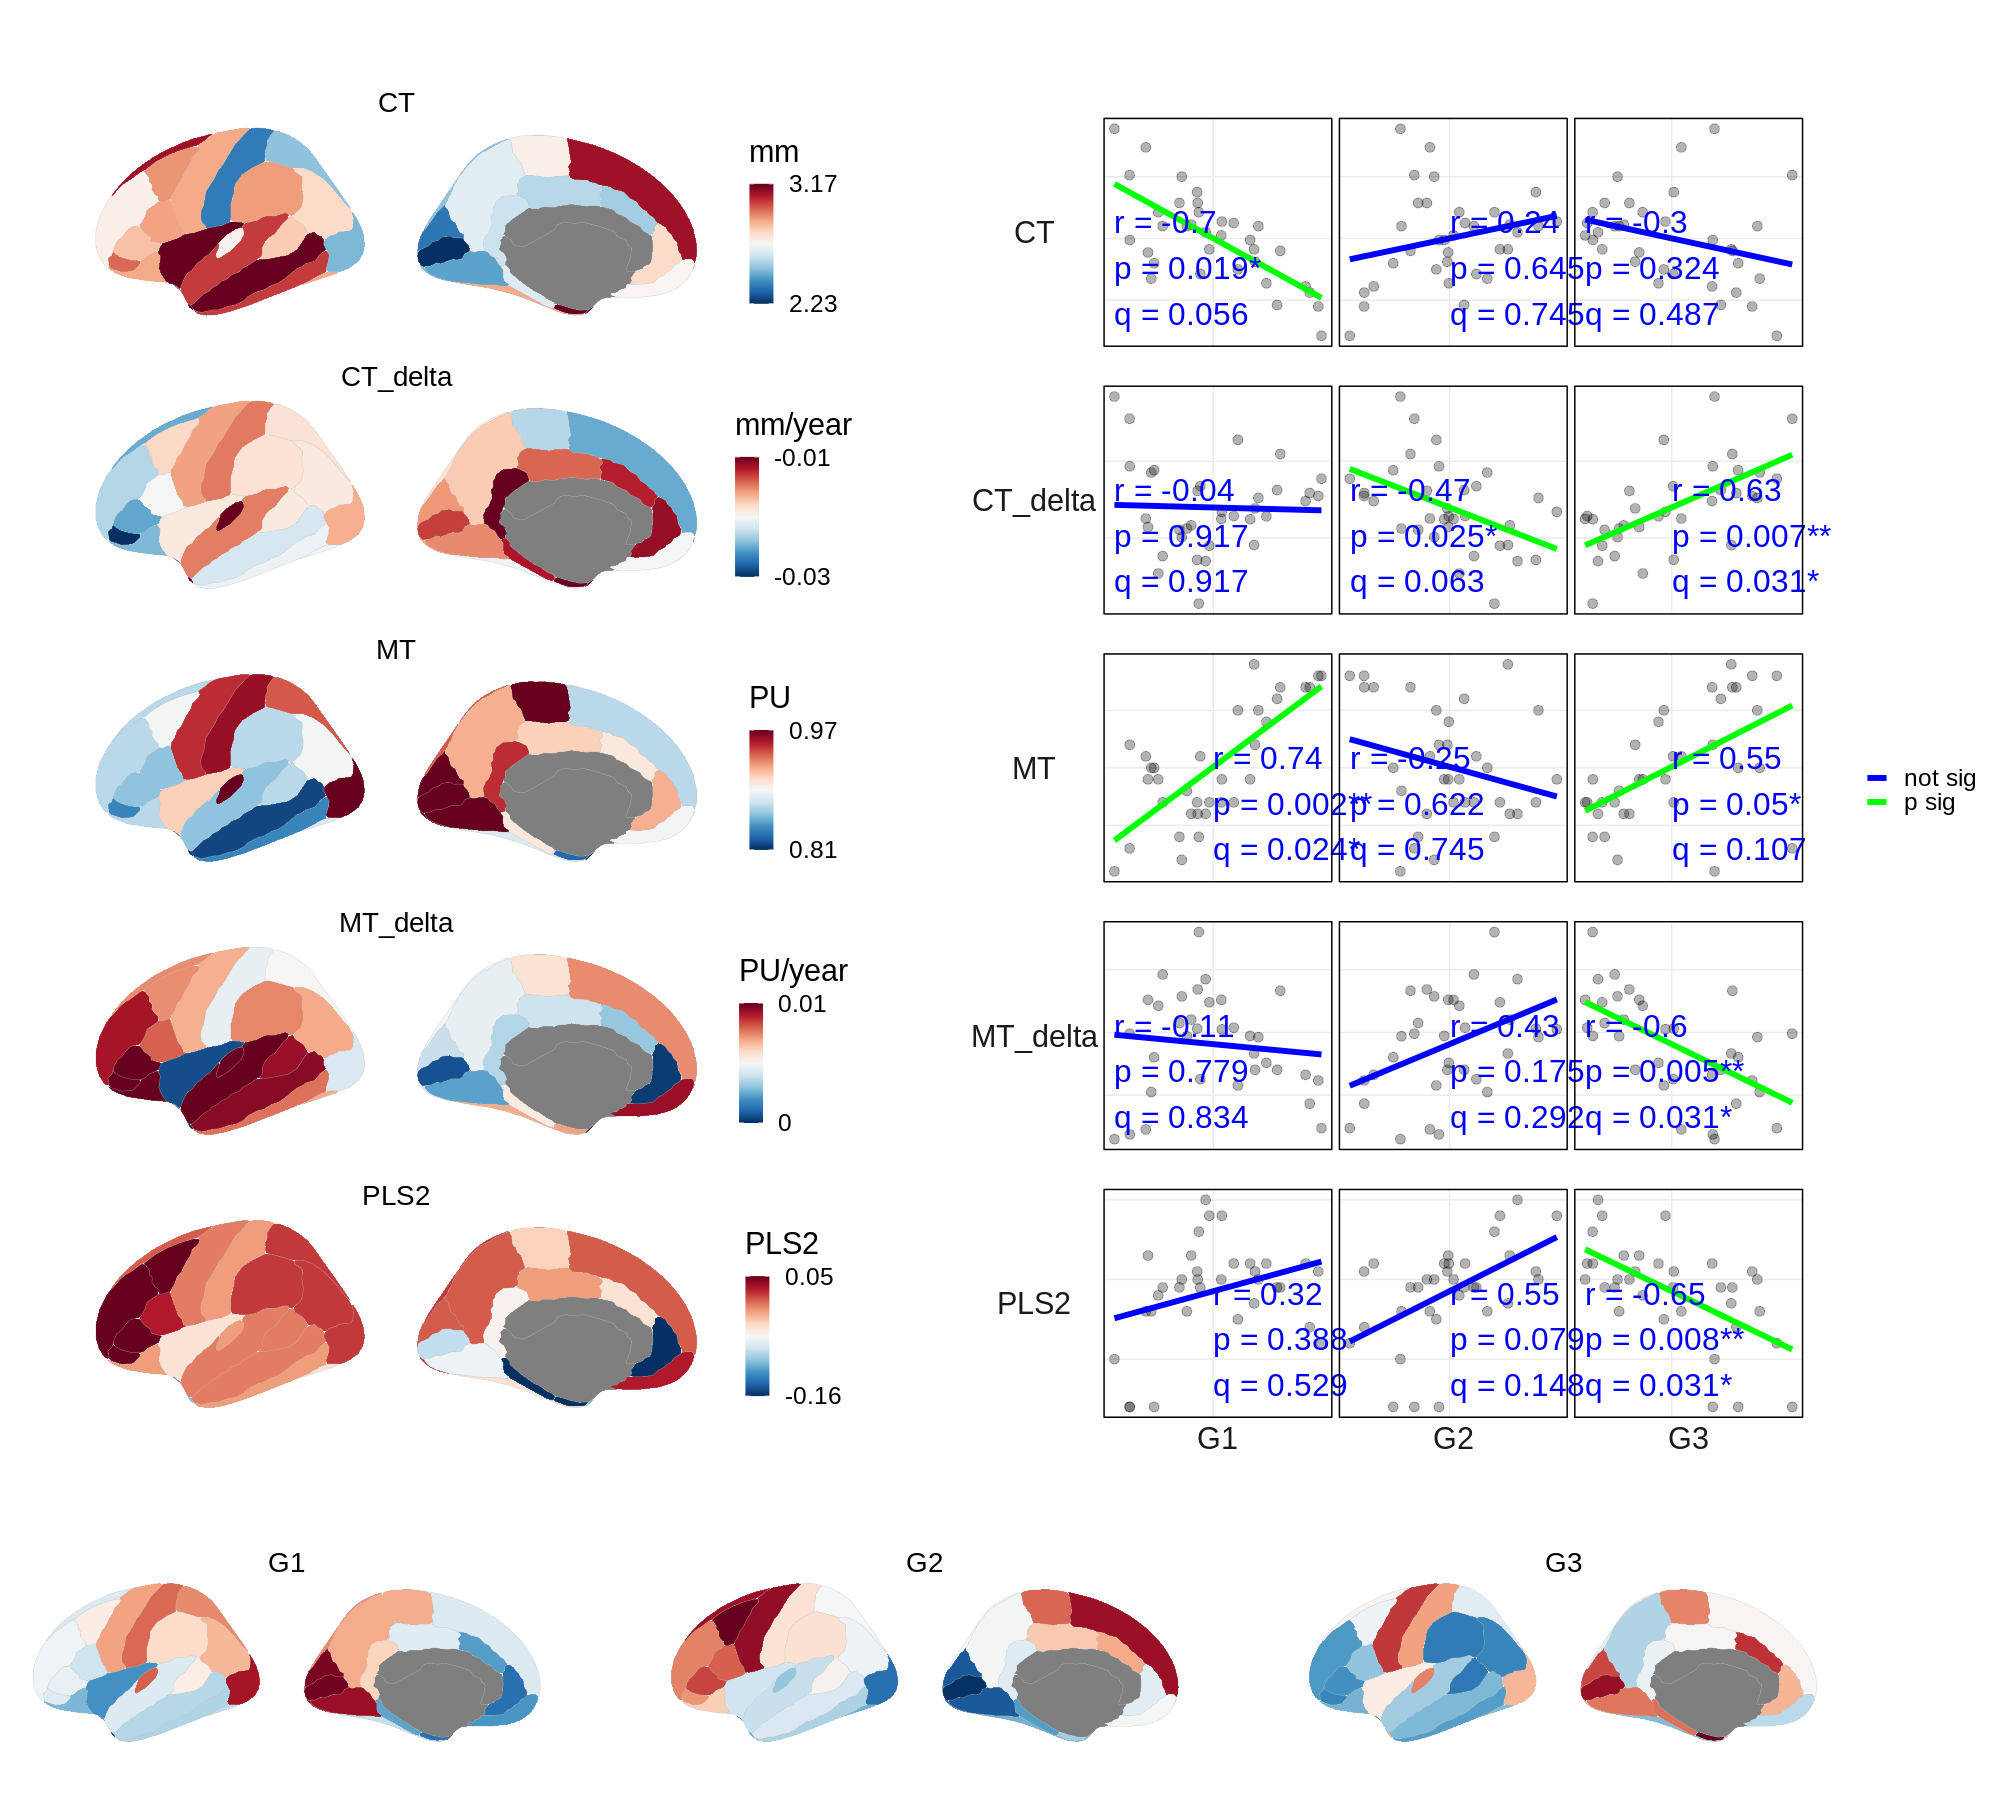

In [34]:
%%R -i dk_scores -i ct_mt -i ct_mt_scatter -i ct_mt_null_p -w 20 -h 18 --units in -r 100
source("../code/plot_maps.R")
source("../code/brainPlots.R")
ct <- plot_maps_dk(ct_mt %>% select(CT), colorscale='absolute',name='mm')
mt <- plot_maps_dk(ct_mt %>% select(MT), colorscale='absolute',name='PU')
ct_delta <- plot_maps_dk(ct_mt %>% select(CT_delta), colorscale='absolute',name='mm/year')
mt_delta <- plot_maps_dk(ct_mt %>% select(MT_delta), colorscale='absolute',name='PU/year')
pls2 <- plot_maps_dk(ct_mt %>% select(PLS2), colorscale='absolute',name='PLS2')

g0 <- plot_dk_wide(dk_scores) + guides(fill='none')
g <- plot_maps_scatter_explore(ct_mt_scatter, ct_mt_null_p) + 
    theme(panel.border=element_rect(fill=NA), panel.spacing.y=unit(2,'lines')) 
    # ggtitle('FDR sig regions only')

(((ct / ct_delta / mt / mt_delta / pls2) | g) / g0 + plot_layout(heights=c(5,1))) & 
theme(legend.position='right', text=element_text(size=22), strip.text=element_text(size=22))

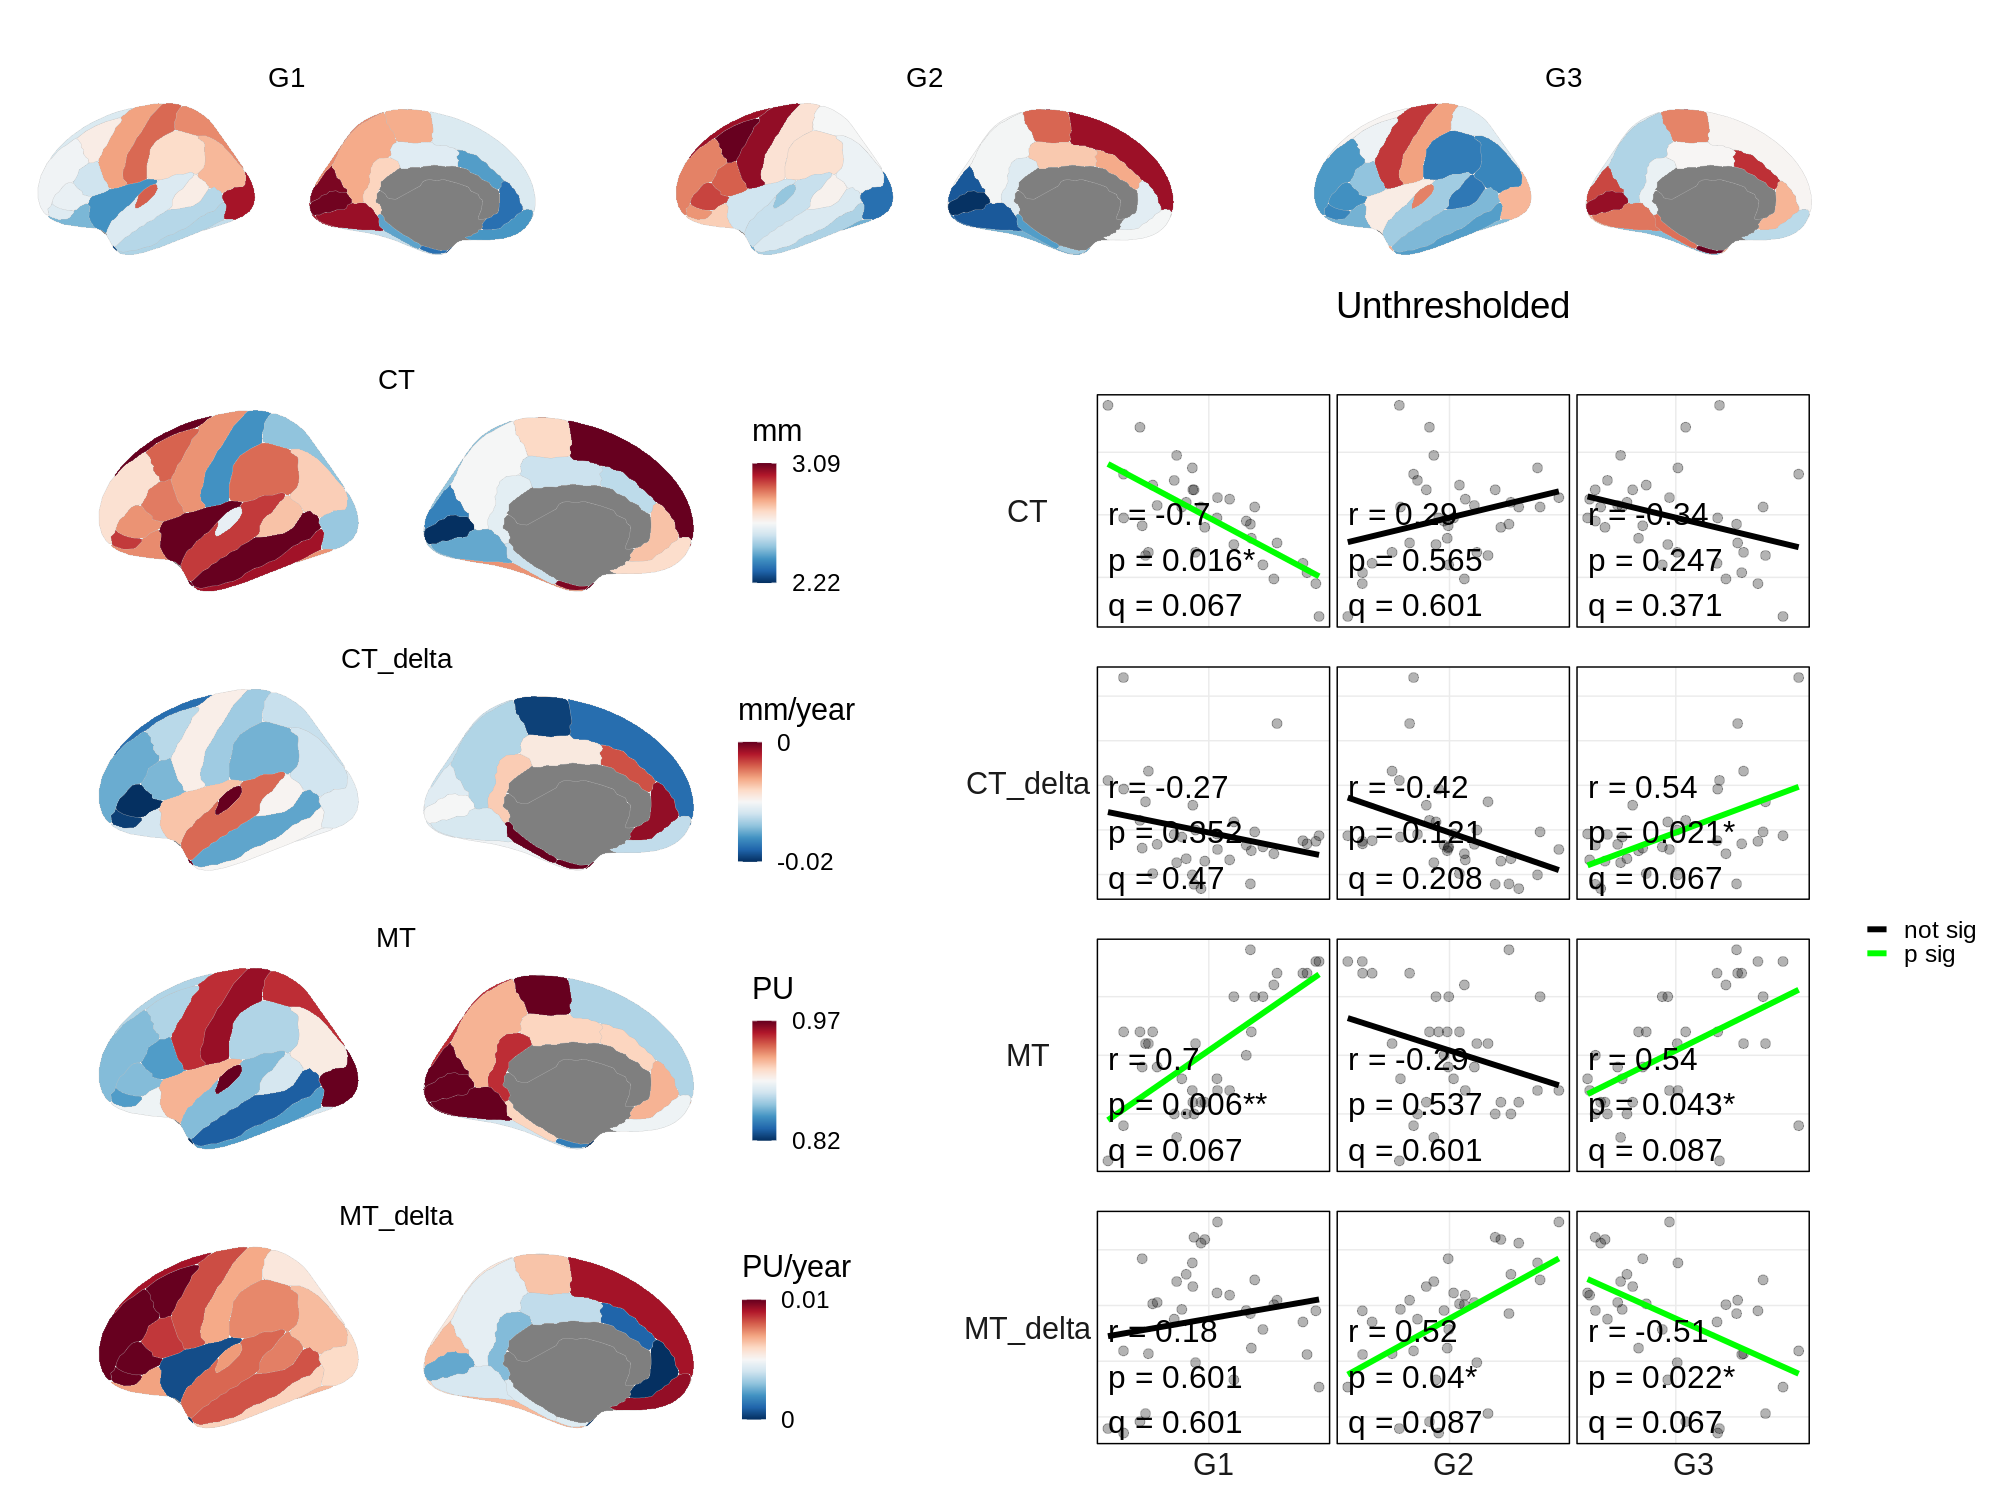

In [189]:
%%R -i dk_scores -i ct_mt -i ct_mt_scatter -i ct_mt_null_p -w 20 -h 15 --units in -r 100
source("../code/plot_maps.R")
ct <- plot_maps_dk(ct_mt %>% select(CT), colorscale='absolute',name='mm')
mt <- plot_maps_dk(ct_mt %>% select(MT), colorscale='absolute',name='PU')
ct_delta <- plot_maps_dk(ct_mt %>% select(CT_delta), colorscale='absolute',name='mm/year')
mt_delta <- plot_maps_dk(ct_mt %>% select(MT_delta), colorscale='absolute',name='PU/year')

g0 <- plot_dk_wide(dk_scores) + guides(fill='none')
g <- plot_maps_scatter(ct_mt_scatter, ct_mt_null_p) + 
    theme(panel.border=element_rect(fill=NA), panel.spacing.y=unit(2,'lines')) + 
    ggtitle('Unthresholded')

(g0 / ((ct / ct_delta / mt / mt_delta) | g) + plot_layout(heights=c(1,5))) & 
theme(legend.position='right', text=element_text(size=22), strip.text=element_text(size=22))